#### [Raw data](http://www.soest.hawaii.edu/pibhmc/cms/data-by-location/american-samoa/)

- *Observational*: ~6 coral groups TBD; "*_TOAD". 

Note that [Rose](http://www.soest.hawaii.edu/pibhmc/cms/data-by-location/american-samoa/rose-atoll/rose-atoll-habitat/) does not have optical validation data, but does have biological characterizations from prior surveys. This may be useful for predictive comparison only.

Note that Swains does not have any biological layers available.

- *Environmental*: (in progress- TBD based on ongoing literature review); 1-6 from PIBHMC site
    1. Depth (from bty: "*_bty")
    2. Hard vs. soft bottom (from Arc ASCII file: "*_hs")
    3. Rugosity (from Arc ASCII file: "*_rugosity")
    4. Slope (from Arc ASCII file: "*_slope")
    5. PASS 3/20: this attribute is rarely identified as influential...I'm going to exclude it for now..Curvature (from bty)
    6. Aspect (from bty)
    7. PASS 3/19: Buildings (from PacIOOS: "*_bldngs*"; not available for Rose, Swains). Not loading properly...ignore for now
    8. Environmental sensitivity index (from PacIOOS: "AS_all/Env_sens_index")
    9. Village boundaries (from PacIOOS: "AS_all/Villages/")
    10. Distance from shore (from PacIOOS: "AS_all/Shorelines/")
    11. Wetland proximity (from PacIOOS: "AS_all/Wetlands/")
    12. Population 1960-2000 (from PacIOOS: "AS_all/Population/")
    13. ROMS u velocity (to E) (3 km resolution; from PacIOOS: "AS_all/Currents")
    14. ROMS v velocity (to N) (3 km resolution; from PacIOOS: "AS_all/Currents")

Priority locations:  Ofu-Olosega, Ta‘u, Tutuila
Secondary locations: Rose Atoll, Swains Island

All PIBHMC data is available at 5 m resolution for all locations except for Swains Island (5 m for bty, 40 m for hs, rugosity, slope). Using integrated data when available for completeness of coverage.

#### Load libraries

In [39]:
library(data.table)
library(geojsonio)
library(GISTools)
library(ncdf4)
library(raster)
library(rgdal)
library(rgeos)
library(sf)
library(spatial.tools)
library(tidyverse)

#### Load raw data

I need to...
- [done] load the observational and predictor data for each region (OfuOlo, Rose, Swains, Tau, Tut) and all regions (AS_all)
- [done] choose prj, ensure projections align
- [done] exclude depths < 30 m and > 200 m**
- [done] crop rasters
- [done] resample rasters to 50 m resolution
- [done] load netcdfs, reproject, save as points shp

## Ofu-Olo

In [149]:
setwd("C:/Users/linds/OneDrive/Documents/samoa_corals_data/")

# Ofu-Olosega
oo_bty <-raster('OfuOlo/OfuOlo_bty/oo_dbmb_mos4.asc')
oo_hs <- raster('OfuOlo/OfuOlo_hs/ofu_5m_hs_int.asc')
oo_rug <- raster('OfuOlo/OfuOlo_rugosity/OfuOlo_5m_Rugosity.asc')
oo_slope <- raster('OfuOlo/OfuOlo_slope/OfuOlo_5m_Slope.asc')
oo_TOAD <- st_read('OfuOlo/OfuOlo_TOAD/OFU_TOAD_ALL2.shp') # for reading the attribute table

# Assign projection
proj4string(oo_bty) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(oo_hs) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(oo_rug) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(oo_slope) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
oo_TOAD <- st_transform(oo_TOAD, crs= st_crs(oo_bty))

# Create aspect raster
oo_aspect <- terrain(oo_bty, opt = "aspect", unit = "degrees")

Reading layer `OFU_TOAD_ALL2' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\OfuOlo\OfuOlo_TOAD\OFU_TOAD_ALL2.shp' using driver `ESRI Shapefile'
Simple feature collection with 3042 features and 97 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -169.6982 ymin: -14.19928 xmax: -169.5957 ymax: -14.13887
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


#### Clip bathymetry raster < 30 m, > 200 m; crop others to same extent; resample rasters

In [150]:
oo_bty[oo_bty > -30] <- NA
oo_bty[oo_bty < -200] <- NA

oo_hs <- crop(oo_hs, oo_bty)
oo_rug <- crop(oo_rug, oo_bty)
oo_slope <- crop(oo_slope, oo_bty)
oo_aspect <- crop(oo_aspect, oo_bty)

# Resample rasters to a resolution of 50 m (factor of 10)
oo_bty <- aggregate(oo_bty, fact=10)
oo_hs <- aggregate(oo_hs, fact=10)
oo_rug <- aggregate(oo_rug, fact=10)
oo_slope <- aggregate(oo_slope, fact=10)
oo_aspect <- aggregate(oo_aspect, fact=10)

# Write tranformed rasters and shp to file
writeRaster(oo_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_bty',
                                       "oo_bty.grd"), format='raster', overwrite=TRUE)
writeRaster(oo_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_hs',
                                       "oo_hs.grd"), format='raster', overwrite=TRUE)
writeRaster(oo_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_rugosity',
                                       "oo_rug.grd"), format='raster', overwrite=TRUE)
writeRaster(oo_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_slope',
                                       "oo_slope.grd"), format='raster', overwrite=TRUE)
writeRaster(oo_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_asp',
                                       "oo_aspect.grd"), format='raster', overwrite=TRUE)
st_write(obj=oo_TOAD, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_TOAD', 
         update=TRUE, driver="ESRI Shapefile", 'oo_TOAD.shp')

#### Isolate points (testing)

In [91]:
colnames(oo_black_coral)

[1] "ID"         "Type"       "P_V"        "VidScheme"  "Island"    
 [6] "Cruise"     "Record"     "Tow_ID"     "Date_UTC"   "Time_UTC"  
[11] "Lat"        "Long"       "Distance"   "Adj_Depth"  "DepthBin"  
[16] "Image"      "Image_Time" "S1"         "S2"         "S3"        
[21] "S4"         "S5"         "T1_1"       "T1_2"       "T1_3"      
[26] "T1_4"       "T1_5"       "T2_1"       "T2_2"       "T2_3"      
[31] "T2_4"       "T2_5"       "T3_1"       "T3_2"       "T3_3"      
[36] "T3_4"       "T3_5"       "Cavities"   "Comments"   "Bleaching" 
[41] "Unconsolid" "Mud"        "Sand"       "Hard_Botto" "Rubble"    
[46] "Boulder"    "Rock"       "Manmade"    "Unclass_S"  "Hard_Coral"
[51] "Soft_Coral" "Crustose_C" "Turf_Algae" "Seagrass"   "Macroalgae"
[56] "Sessile_In" "Uncolonize" "Unclass_T1" "Branching"  "Columnar"  
[61] "Encrusting" "Free_Livin" "Foliose"    "Massive"    "Tabulate"  
[66] "Unclass_mo" "NonSclerac" "Black_Cora" "Octocoral"  "Unclass_So"
[71] "Invisible_" "Visible_Tu" "Unclass_Tu" "Cyanobacte" "Encrusti_1"
[76] "Halimeda"   "Upright_Ma" "Unclass_Ma" "Anemone"    "Bivalve"   
[81] "Bryzoan"    "Corallimor" "Giant_Clam" "Sponge"     "Tunicate"  
[86] "Zoanthid"   "Unclass_In" "Null_T2"    "Acropora"   "Euphyllia" 
[91] "Leptoseris" "Montipora"  "Other_Cora" "Porites"    "Pocillopor"
[96] "Unclassifi" "Null_T3"    "geometry"

In [118]:
# Isolating black coral points
oo_TOAD_black_coral <- oo_TOAD[,c(68)]
oo_TOAD_black_coral <- as.data.frame(oo_TOAD_black_coral)

# Separate UTM coordinates from geometry column
oo_TOAD_black_coral <- oo_TOAD_black_coral %>%
    mutate(lat = unlist(map(oo_TOAD_black_coral$geometry,1)),
           long = unlist(map(oo_TOAD_black_coral$geometry,2)))

# Drop geometry column
oo_TOAD_black_coral$geometry <- NULL

## Tau

In [164]:
# Tau
tau_bty <-raster('Tau/Tau_bty/tau_dbmb_mos.asc')
tau_hs <- raster('Tau/Tau_hs/tau_5m_hs_int.asc')
tau_rug <- raster('Tau/Tau_rugosity/Tau_5m_Rugosity.asc')
tau_slope <- raster('Tau/Tau_slope/Tau_5m_Slope.asc')
tau_TOAD <- st_read('Tau/Tau_TOAD/Toad_Tau_all2.shp')
                    
proj4string(tau_bty) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tau_hs) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tau_rug) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tau_slope) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
tau_TOAD <- st_transform(tau_TOAD, crs= st_crs(tau_bty))

tau_aspect <- terrain(tau_bty, opt = "aspect", unit = "degrees")

# tau_bty # view raster attributes                   

Reading layer `Toad_Tau_all2' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\Tau\Tau_TOAD\Toad_Tau_all2.shp' using driver `ESRI Shapefile'
Simple feature collection with 1276 features and 97 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -169.553 ymin: -14.28124 xmax: -169.4154 ymax: -14.20876
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


#### Clip bathymetry raster < 30 m, > 200 m; crop others to same extent; resample rasters

In [165]:
tau_bty[tau_bty > -30] <- NA
tau_bty[tau_bty < -200] <- NA

tau_hs <- crop(tau_hs, tau_bty)
tau_rug <- crop(tau_rug, tau_bty)
tau_slope <- crop(tau_slope, tau_bty)
tau_aspect <- crop(tau_aspect, tau_bty)

# Resample rasters to a resolution of 50 m (factor of 10)
tau_bty <- aggregate(tau_bty, fact=10)
tau_hs <- aggregate(tau_hs, fact=10)
tau_rug <- aggregate(tau_rug, fact=10)
tau_slope <- aggregate(tau_slope, fact=10)
tau_aspect <- aggregate(tau_aspect, fact=10)

# Write tranformed rasters and shp to file
writeRaster(tau_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_bty',
                                       "tau_bty.grd"), format='raster', overwrite=TRUE)
writeRaster(tau_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_hs',
                                       "tau_hs.grd"), format='raster', overwrite=TRUE)
writeRaster(tau_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_rugosity',
                                       "tau_rug.grd"), format='raster', overwrite=TRUE)
writeRaster(tau_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_slope',
                                       "tau_slope.grd"), format='raster', overwrite=TRUE)
writeRaster(tau_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_asp',
                                       "tau_aspect.grd"), format='raster', overwrite=TRUE)
st_write(obj=tau_TOAD, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/Tau_TOAD', 
         update=TRUE, driver="ESRI Shapefile", 'tau_TOAD.shp')

## Tutuila

In [14]:
tut_bty <-raster('Tut/Tut_bty/tut_dbmb.asc')
tut_hs <- raster('Tut/Tut_hs/tut-re8101-unspv-5m.tif')
tut_rug <- raster('Tut/Tut_rugosity/Tutuila_5m_Rugosity.asc')
tut_slope <- raster('Tut/Tut_slope/Tutuila_5m_Slope.asc')
tut_TOAD <- st_read('Tut/Tut_TOAD/tut_toad_all.shp')

proj4string(tut_bty) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tut_hs) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tut_rug) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(tut_slope) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
tut_TOAD <- st_transform(tut_TOAD, crs= st_crs(tut_bty))

tut_aspect <- terrain(tut_bty, opt = "aspect", unit = "degrees")

Reading layer `tut_toad_all' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\Tut\Tut_TOAD\tut_toad_all.shp' using driver `ESRI Shapefile'
Simple feature collection with 5602 features and 107 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -170.9227 ymin: -14.3715 xmax: -170.4948 ymax: -14.20533
epsg (SRID):    4267
proj4string:    +proj=longlat +ellps=clrk66 +no_defs


#### Clip bathymetry raster < 30 m, > 200 m; crop others to same extent; resample rasters

In [15]:
tut_bty[tut_bty > -30] <- NA
tut_bty[tut_bty < -200] <- NA

tut_hs <- crop(tut_hs, tut_bty)
tut_rug <- crop(tut_rug, tut_bty)
tut_slope <- crop(tut_slope, tut_bty)
tut_aspect <- crop(tut_aspect, tut_bty)

tut_bty <- aggregate(tut_bty, fact=10)
tut_hs <- aggregate(tut_hs, fact=10)
tut_rug <- aggregate(tut_rug, fact=10)
tut_slope <- aggregate(tut_slope, fact=10)
tut_aspect <- aggregate(tut_aspect, fact=10)

# Write tranformed rasters and shp to file
writeRaster(tut_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_bty',
                                       "tut_bty.grd"), format='raster', overwrite=TRUE)
writeRaster(tut_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_hs',
                                       "tut_hs.grd"), format='raster', overwrite=TRUE)
writeRaster(tut_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_rugosity',
                                       "tut_rug.grd"), format='raster', overwrite=TRUE)
writeRaster(tut_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_slope',
                                       "tut_slope.grd"), format='raster', overwrite=TRUE)
writeRaster(tut_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_asp',
                                       "tut_aspect.grd"), format='raster', overwrite=TRUE)
st_write(obj=tut_TOAD, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/Tut_TOAD', 
         update=TRUE, driver="ESRI Shapefile", 'tut_TOAD.shp')

## Rose Atoll

In [170]:
rose_bty <-raster('Rose/Rose_bty/rose_5m_dbmb.asc')
rose_hs <- raster('Rose/Rose_hs/ros_5m_hs_int.asc')
rose_rug <- raster('Rose/Rose_rugosity/ros_5m_rug.asc')
rose_slope <- raster('Rose/Rose_slope/ros_5m_slp.asc')

proj4string(rose_bty) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(rose_hs) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(rose_rug) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(rose_slope) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")

rose_aspect <- terrain(rose_bty, opt = "aspect", unit = "degrees")

#### Clip bathymetry raster < 30 m, > 200 m; crop others to same extent; resample rasters

In [171]:
rose_bty[rose_bty > -30] <- NA
rose_bty[rose_bty < -200] <- NA

rose_hs <- crop(rose_hs, rose_bty)
rose_rug <- crop(rose_rug, rose_bty)
rose_slope <- crop(rose_slope, rose_bty)
rose_aspect <- crop(rose_aspect, rose_bty)

rose_bty <- aggregate(rose_bty, fact=10)
rose_hs <- aggregate(rose_hs, fact=10)
rose_rug <- aggregate(rose_rug, fact=10)
rose_slope <- aggregate(rose_slope, fact=10)
rose_aspect <- aggregate(rose_aspect, fact=10)

In [172]:
# Write tranformed rasters
writeRaster(rose_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_bty',
                                       "rose_bty.grd"), format='raster', overwrite=TRUE)
writeRaster(rose_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_hs',
                                       "rose_hs.grd"), format='raster', overwrite=TRUE)
writeRaster(rose_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_rugosity',
                                       "rose_rug.grd"), format='raster', overwrite=TRUE)
writeRaster(rose_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_slope',
                                       "rose_slope.grd"), format='raster', overwrite=TRUE)
writeRaster(rose_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_asp',
                                       "rose_aspect.grd"), format='raster', overwrite=TRUE)

class      : RasterLayer 
dimensions : 84, 92, 7728  (nrow, ncol, ncell)
resolution : 50.0109, 50.0109  (x, y)
extent     : 804400, 809001, 8388065, 8392266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_bty/rose_bty.grd 
names      : rose_5m_dbmb 
values     : -199.771, -30.1904  (min, max)


class      : RasterLayer 
dimensions : 84, 92, 7728  (nrow, ncol, ncell)
resolution : 50.0109, 50.0109  (x, y)
extent     : 804400, 809001, 8388065, 8392266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_hs/rose_hs.grd 
names      : rose_5m_dbmb 
values     : -199.771, -30.1904  (min, max)


class      : RasterLayer 
dimensions : 84, 92, 7728  (nrow, ncol, ncell)
resolution : 50.0109, 50.0109  (x, y)
extent     : 804400, 809001, 8388065, 8392266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_rugosity/rose_rug.grd 
names      : rose_5m_dbmb 
values     : -199.771, -30.1904  (min, max)


class      : RasterLayer 
dimensions : 84, 92, 7728  (nrow, ncol, ncell)
resolution : 50.0109, 50.0109  (x, y)
extent     : 804400, 809001, 8388065, 8392266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_slope/rose_slope.grd 
names      : rose_5m_dbmb 
values     : -199.771, -30.1904  (min, max)


class      : RasterLayer 
dimensions : 84, 92, 7728  (nrow, ncol, ncell)
resolution : 50.0109, 50.0109  (x, y)
extent     : 804400, 809001, 8388065, 8392266  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Rose/Rose_asp/rose_aspect.grd 
names      : rose_5m_dbmb 
values     : -199.771, -30.1904  (min, max)


## Swains Island

In [173]:
swains_bty <-raster('Swains/Swains_bty/swa_dbmb_5m.asc')
swains_hs <- raster('Swains/Swains_hs/swains_40m_hardsoft.asc')
swains_rug <- raster('Swains/Swains_rugosity/swa_40m_rug.asc')
swains_slope <- raster('Swains/Swains_slope/swa_40m_slp.asc')

proj4string(swains_bty) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(swains_hs) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(swains_rug) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
proj4string(swains_slope) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")

swains_aspect <- terrain(swains_bty, opt = "aspect", unit = "degrees")

#### Clip bathymetry raster < 30 m, > 200 m; crop others to same extent; resample rasters

In [174]:
swains_bty[swains_bty > -30] <- NA
swains_bty[swains_bty < -200] <- NA

swains_hs <- crop(swains_hs, swains_bty)
swains_rug <- crop(swains_rug, swains_bty)
swains_slope <- crop(swains_slope, swains_bty)
swains_aspect <- crop(swains_aspect, swains_bty)

swains_bty <- aggregate(swains_bty, fact=10)

swains_hs <- disaggregate(swains_hs, fact=4)
swains_hs <- aggregate(swains_hs, fact=5)

swains_rug <- disaggregate(swains_rug, fact=4)
swains_rug <- aggregate(swains_rug, fact=5)

swains_slope <- disaggregate(swains_slope, fact=4)
swains_slope <- aggregate(swains_slope, fact=5)

swains_aspect <- aggregate(swains_aspect, fact=10)

In [176]:
# Write tranformed rasters and shp to file
writeRaster(swains_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_bty',
                                       "swains_bty.grd"), format='raster', overwrite=TRUE)
writeRaster(swains_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_hs',
                                       "swains_hs.grd"), format='raster', overwrite=TRUE)
writeRaster(swains_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_rugosity',
                                       "swains_rug.grd"), format='raster', overwrite=TRUE)
writeRaster(swains_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_slope',
                                       "swains_slope.grd"), format='raster', overwrite=TRUE)
writeRaster(swains_bty, filename=file.path('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_asp',
                                       "swains_aspect.grd"), format='raster', overwrite=TRUE)

class      : RasterLayer 
dimensions : 61, 73, 4453  (nrow, ncol, ncell)
resolution : 50, 50  (x, y)
extent     : 489660.1, 493310.1, 8776165, 8779215  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_bty/swains_bty.grd 
names      : swa_dbmb_5m 
values     : -196.91, -30.3  (min, max)


class      : RasterLayer 
dimensions : 61, 73, 4453  (nrow, ncol, ncell)
resolution : 50, 50  (x, y)
extent     : 489660.1, 493310.1, 8776165, 8779215  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_hs/swains_hs.grd 
names      : swa_dbmb_5m 
values     : -196.91, -30.3  (min, max)


class      : RasterLayer 
dimensions : 61, 73, 4453  (nrow, ncol, ncell)
resolution : 50, 50  (x, y)
extent     : 489660.1, 493310.1, 8776165, 8779215  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_rugosity/swains_rug.grd 
names      : swa_dbmb_5m 
values     : -196.91, -30.3  (min, max)


class      : RasterLayer 
dimensions : 61, 73, 4453  (nrow, ncol, ncell)
resolution : 50, 50  (x, y)
extent     : 489660.1, 493310.1, 8776165, 8779215  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_slope/swains_slope.grd 
names      : swa_dbmb_5m 
values     : -196.91, -30.3  (min, max)


class      : RasterLayer 
dimensions : 61, 73, 4453  (nrow, ncol, ncell)
resolution : 50, 50  (x, y)
extent     : 489660.1, 493310.1, 8776165, 8779215  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs 
source     : C:/Users/linds/OneDrive/Documents/samoa_corals_data/Swains/Swains_asp/swains_aspect.grd 
names      : swa_dbmb_5m 
values     : -196.91, -30.3  (min, max)


## American Samoa (all)
Load the u (eastward) currents nc file first:

In [139]:
setwd('C:/Users/linds/OneDrive/Documents/samoa_corals_data/')
currents <- nc_open('AS_all/Currents/currents.nc')
#str(currents)

In [140]:
v1 = currents$var[[1]] 
u = ncvar_get(currents, v1) # 2929
lon = v1$dim[[1]]$vals # dim[[1]] is lon - 186
lat = v1$dim[[2]]$vals # dim[[2]] is lat - 112

# Using deconstruct function c() to turn matrices into numeric class output
uvals <- c(u) # length = 61016928, which is u*lon*lat
df <- as.data.frame(uvals)

# Same lat applied to 186 uvals at a time (there are 186 lon values before they repeat)
latlist <- rep(lat,each=186)
# 1 column and 61016928 (112*186*2929) rows in uvel 
colnames(df) <- "u"
lonlist <- rep(lon, times=112)
df$lon <- lonlist
df$lat <- latlist

d <- split(df, rep(1:2929, each=20832))
merged <- d %>% reduce(left_join, by=c("lat", "lon"), all=FALSE)
udf <- data.frame(lon=merged[,2], lat=merged[,3], umean=rowMeans(merged[,-c(2,3)]))

Next, load the v (westward) currents:

In [141]:
v3 = currents$var[[3]] 
v = ncvar_get(currents, v3)
lon = v3$dim[[1]]$vals # dim[[1]] is lon - 186
lat = v3$dim[[2]]$vals # dim[[2]] is lat - 112
vvals <- c(v) # length = 61016928, which is v*lon*lat
df2 <- as.data.frame(vvals)
latlist <- rep(lat,each=186) 
colnames(df) <- "v"
lonlist <- rep(lon, times=112)
df2$lon <- lonlist
df2$lat <- latlist


d2 <- split(df2, rep(1:2929, each=20832))
merged2 <- d2 %>% reduce(left_join, by=c("lat", "lon"), all=FALSE)
vdf <- data.frame(lon=merged2[,2], lat=merged2[,3], vmean=rowMeans(merged[,-c(2,3)]))

# Write CSVs to file
udf <- na.omit(udf)
vdf <- na.omit(vdf)
write.csv(udf, 'AS_all/Currents/udf.csv', row.names = FALSE)
write.csv(vdf, 'AS_all/Currents/vdf.csv', row.names = FALSE)

In [147]:
# Reload a "raw", untransformed raster
tut_slope_raw <- raster('Tut/Tut_slope/Tutuila_5m_Slope.asc')
proj4string(tut_slope_raw) <- CRS("+proj=longlat +datum=WGS84 +no_defs")
crs(tut_slope_raw)

# Create CRS objects
utm_crs <- crs(tut_bty)
wgs_crs <- crs(tut_slope_raw)

# Assign the original CRS to a new SpatialPointsDataFrame object
udf_sp <- SpatialPointsDataFrame(udf[,1:2], udf, proj4string = wgs_crs)
vdf_sp <- SpatialPointsDataFrame(vdf[,1:2], vdf, proj4string = wgs_crs)

# Check CRS
#crs(udf_sp)
#extent(udf_sp)

# Write as a shapefile
writeOGR(obj=udf_sp, layer="umean", 
         dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Currents', driver="ESRI Shapefile",
        overwrite_layer=TRUE)
writeOGR(obj=vdf_sp, layer="vmean", 
         dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Currents', driver="ESRI Shapefile",
         overwrite_layer=TRUE)

# Reload and transform
ucur <- st_read('AS_all/Currents/umean.shp')
ucur <- st_transform(ucur, crs= st_crs(tut_bty))
vcur <- st_read('AS_all/Currents/vmean.shp')
vcur <- st_transform(vcur, crs= st_crs(tut_bty))

# Write as a tranformed shapefile
st_write(obj=ucur, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Currents', 
         update=TRUE, driver="ESRI Shapefile", 'ucur.shp')
st_write(obj=vcur, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Currents', 
         update=TRUE, driver="ESRI Shapefile", 'vcur.shp')

CRS arguments:
 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

Reading layer `umean' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\umean.shp' using driver `ESRI Shapefile'
Simple feature collection with 20359 features and 3 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -174 ymin: -15.5 xmax: -168.8088 ymax: -12.49855
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
Reading layer `vmean' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\vmean.shp' using driver `ESRI Shapefile'
Simple feature collection with 20359 features and 3 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -174 ymin: -15.5 xmax: -168.8088 ymax: -12.49855
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs
Updating layer `ucur' to data source `C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Currents' using driver `ESRI Shapefile'
Updating existing layer ucur
Writing 20359 features with 3 fields and geometr

Load the remainder of the data:

In [4]:
ucur <- st_read('AS_all/Currents/ucur.shp')
vcur <- st_read('AS_all/Currents/vcur.shp')

esi <- st_read('AS_all/Env_sens_index/esi_raw.shp')
pop <- st_read('AS_all/Population/pop_raw.shp')
shore <- st_read('AS_all/Shorelines/shore_raw.shp')
villages <- st_read('AS_all/Villages/villages_raw.shp')
wetlands <- st_read('AS_all/Wetlands/wl_raw.shp')

esi <- st_transform(esi, crs= st_crs(tut_bty))
pop <- st_transform(pop, crs= st_crs(tut_bty))
shore <- st_transform(shore, crs= st_crs(tut_bty))
villages <- st_transform(villages, crs= st_crs(tut_bty))
wetlands <- st_transform(wetlands, crs= st_crs(tut_bty))

# Write as a tranformed shapefile
st_write(obj=esi, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Env_sens_index', 
         update=TRUE, driver="ESRI Shapefile", 'esi.shp')
st_write(obj=pop, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Population', 
         update=TRUE, driver="ESRI Shapefile", 'pop.shp')
st_write(obj=shore, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Shorelines', 
         update=TRUE, driver="ESRI Shapefile", 'shore.shp')
st_write(obj=vcur, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Villages', 
         update=TRUE, driver="ESRI Shapefile", 'villages.shp')
st_write(obj=ucur, dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/AS_all/Wetlands', 
         update=TRUE, driver="ESRI Shapefile", 'wl.shp')

Reading layer `ucur' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\ucur.shp' using driver `ESRI Shapefile'
Simple feature collection with 122154 features and 3 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: 173899.2 ymin: 8284117 xmax: 738140.2 ymax: 8618317
epsg (SRID):    NA
proj4string:    +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs
Reading layer `vcur' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\vcur.shp' using driver `ESRI Shapefile'
Simple feature collection with 122154 features and 3 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: 173899.2 ymin: 8284117 xmax: 738140.2 ymax: 8618317
epsg (SRID):    NA
proj4string:    +proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs
Reading layer `esi_raw' from data source `C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Env_sens_index\esi_raw.shp' using driver `ESRI Shapefile'
Simple feature 

## Create dataframe for model training

I need to...
- [done] clean up shapefiles, i.e. ensure each 50 m cell only has a single observation; rasterize, then reconvert to points shapefile
- [done] extract data from rasters to points
- calculate Euclidean distance/extract closest values for:
    - Environmental sensitivity index (from PacIOOS: "AS_all/Env_sens_index")
    - Village boundaries (from PacIOOS: "AS_all/Villages/")
    - Distance from shore (from PacIOOS: "AS_all/Shorelines/")
    - Wetland proximity (from PacIOOS: "AS_all/Wetlands/")
    - Population 1960-2000 (from PacIOOS: "AS_all/Population/")
    - ROMS u velocity (to E) (3 km resolution; from PacIOOS: "AS_all/Currents")
    - ROMS v velocity (to N) (3 km resolution; from PacIOOS: "AS_all/Currents")
- impute missing data as needed

#### Rasterize TOAD shapefiles
For each coral grouping, an unknown number of 50 m cells have multiple, possibly conflicting, observations. With this protocol, the 1s are preserved within the resulting raster.

##### Black coral (testing)

In [9]:
# Rerun this line (after 4/8)
utm_crs <- crs(tut_bty)

# Set up a raster "template" to use in rasterize()
oo_extent <-  extent(oo_bty)
xy <- abs(apply(as.matrix(bbox(oo_extent)), 1, diff))
n <- 5
r <- raster(oo_extent, ncol=xy[1]*n, nrow=xy[2]*n)
proj4string(r) <- CRS("+proj=utm +zone=2 +south +ellps=GRS80 +units=m +no_defs")
# res(r) is currently 0.2; resample raster to a resolution of 50 m (factor of 250)
r <- aggregate(r, fact=250)

# Rasterize the shapefile
oo_black_coral_r <- rasterize(oo_TOAD[68], r)
#writeRaster(oo_black_coral_r, "oo_black_coral_r.grd")
#plot(oo_black_coral)

# Convert raster to shp
oo_black_coral_pts <- rasterToPoints(oo_black_coral_r, spatial=TRUE)

# Convert to df
oo_black_coral_df <- as.data.frame(oo_black_coral_pts)
# Change name for clarity
names(oo_black_coral_df)[names(oo_black_coral_df) == 'Black_Cora'] = 'Black_Coral_Raw'
# Loop through to populate the binary column
for (i in 1:nrow(oo_black_coral_df)) {
    if (oo_black_coral_df$Black_Coral_Raw[i] == 0) {
        oo_black_coral_df$Black_Coral[i] = 0}  
    else { 
        oo_black_coral_df$Black_Coral[i] = 1
}}

# And finally, reconvert to shp...
# Assign the UTM CRS to a new SpatialPointsDataFrame object
oo_black_coral_sp <- SpatialPointsDataFrame(oo_black_coral_df[,3:4], oo_black_coral_df, proj4string = utm_crs)

# Write as a shapefile
writeOGR(obj=oo_black_coral_sp, layer="Black_Coral", 
         dsn='C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_TOAD', driver="ESRI Shapefile",
        overwrite_layer=TRUE)

# Read back in when needed
oo_black_coral <- readOGR('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/OfuOlo_TOAD/Black_Coral.shp')

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\OfuOlo\OfuOlo_TOAD\Black_Coral.shp", layer: "Black_Coral"
with 857 features
It has 5 fields


#### Extract raster data to observational points

The cell below should be run in a new session (as of 4/8) to reload the clean layers:

In [5]:
setwd("C:/Users/linds/OneDrive/Documents/samoa_corals_data/")

library(data.table)
library(geojsonio)
library(GISTools)
library(ncdf4)
library(raster)
library(rgdal)
library(rgeos)
library(sf)
library(spatial.tools)
library(tidyverse)

# Ofu-Olo
oo_bty <-raster('OfuOlo/OfuOlo_bty/oo_bty.grd')
oo_hs <- raster('OfuOlo/OfuOlo_hs/oo_hs.grd')
oo_rug <- raster('OfuOlo/OfuOlo_rugosity/oo_rug.grd')
oo_slope <- raster('OfuOlo/OfuOlo_slope/oo_slope.grd')
oo_asp <- raster('OfuOlo/OfuOlo_asp/oo_aspect.grd')
oo_TOAD <- readOGR('OfuOlo/OfuOlo_TOAD/oo_TOAD.shp') 

# Tau
tau_bty <-raster('Tau/Tau_bty/tau_bty.grd')
tau_hs <- raster('Tau/Tau_hs/tau_hs.grd')
tau_rug <- raster('Tau/Tau_rugosity/tau_rug.grd')
tau_slope <- raster('Tau/Tau_slope/tau_slope.grd')
tau_asp <- raster('Tau/Tau_asp/tau_aspect.grd')
tau_TOAD <- readOGR('Tau/Tau_TOAD/tau_TOAD.shp') 

# Tut
tut_bty <-raster('Tut/tut_bty/tut_bty.grd')
tut_hs <- raster('Tut/tut_hs/tut_hs.grd')
tut_rug <- raster('Tut/tut_rugosity/tut_rug.grd')
tut_slope <- raster('Tut/tut_slope/tut_slope.grd')
tut_asp <- raster('Tut/tut_asp/tut_aspect.grd')
tut_TOAD <- readOGR('Tut/tut_TOAD/tut_TOAD.shp') 

# Rose 
rose_bty <-raster('Rose/rose_bty/rose_bty.grd')
rose_hs <- raster('Rose/rose_hs/rose_hs.grd')
rose_rug <- raster('Rose/rose_rugosity/rose_rug.grd')
rose_slope <- raster('Rose/rose_slope/rose_slope.grd')
rose_asp <- raster('Rose/rose_asp/rose_aspect.grd')

# Swains
swains_bty <-raster('Swains/swains_bty/swains_bty.grd')
swains_hs <- raster('Swains/swains_hs/swains_hs.grd')
swains_rug <- raster('Swains/swains_rugosity/swains_rug.grd')
swains_slope <- raster('Swains/swains_slope/swains_slope.grd')
swains_asp <- raster('Swains/swains_asp/swains_aspect.grd')

# All
ucur <- readOGR('AS_all/Currents/ucur.shp')
vcur <- readOGR('AS_all/Currents/vcur.shp')
esi <- readOGR('AS_all/Env_sens_index/esi.shp')
pop <- readOGR('AS_all/Population/pop.shp')
shore <- readOGR('AS_all/Shorelines/shore.shp')
villages <- readOGR('AS_all/Villages/villages.shp')
wetlands <- readOGR('AS_all/Wetlands/wl.shp')

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\OfuOlo\OfuOlo_TOAD\oo_TOAD.shp", layer: "oo_TOAD"
with 3042 features
It has 97 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\Tau\Tau_TOAD\tau_TOAD.shp", layer: "tau_TOAD"
with 1276 features
It has 97 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\Tut\Tut_TOAD\tut_TOAD.shp", layer: "tut_TOAD"
with 5602 features
It has 107 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\ucur.shp", layer: "ucur"
with 122154 features
It has 3 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\linds\OneDrive\Documents\samoa_corals_data\AS_all\Currents\vcur.shp", layer: "vcur"
with 122154 features
It has 3 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\

In [181]:
r_tmp <- raster::extract(oo_bty, oo_black_coral)
# length(r_tmp) == nrow(oo_TOAD). Can add as a new column.

#### Calculate Euclidean distance between points and various layers

In [14]:
test<-gDistance(oo_black_coral, ucur, byid=FALSE)

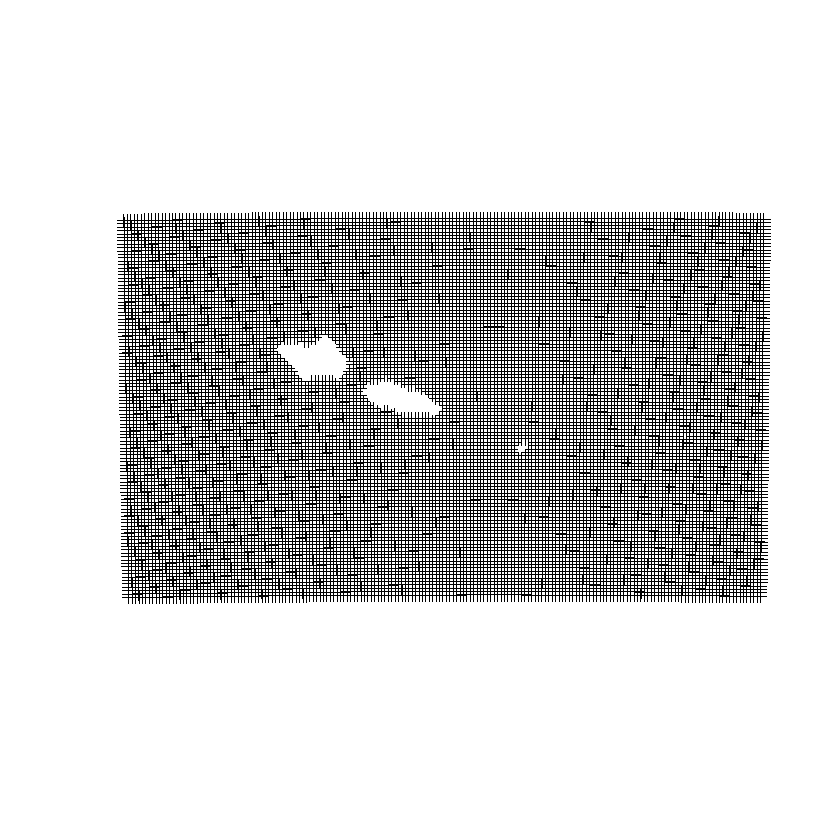

In [17]:
plot(ucur)

#### Notes etc.

- Literature review focusing on priority, then secondary, locations; environmental characteristics of the mesophotic in these areas; mesophotic ecology
- [GeoViews walkthrough for visualization](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- Models: standard GLM classifier, random forest classifier, possibly XGBoost or neural network
- [Metrics for evaluation](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
- [Make nice maps](https://www.benjaminbell.co.uk/2019/08/creating-simple-location-maps-in-r.html)

In [ ]:


#p1 <- SpatialPoints(xy)


### Plot rasters

#histogram(tmin1.c)

#pairs(tmin.all.c)

### Autocorrelation
# Moran(tmin1.c)  # global Moran's I
#tmin1.Moran <- MoranLocal(tmin1.c)
#plot(tmin1.Moran)


#### Now let’s compute the Euclidean distance to these points using the distanceFromPoints function.

# r2.d <- distanceFromPoints(r2, p1) 

# Write edited rasters 
#writeRaster(tmin1.c, filename = "tmin1.c.grd")